## CT5133 / CT5145 Deep Learning (/Online) 2022-2023

## Assignment 2

## James McDermott

* Student ID(s): 20230033
* Student name(s): Jiarong Li

**Due date**: midnight Sunday 19 March (end Week 10).

**Weighting**: 20% of the module.

In this assignment the goal is to take advantage of pre-trained NN models to create an embedding with a dataset of movie posters, and demonstrate how to use that embedding.

The dataset is provided, along with some skeleton code for loading it.

The individual steps to be carried out are specified below, with `### YOUR CODE HERE` markers, together with the number of marks available for each part.

* **Topics**: in Part 5 below, students are asked to add some improvement to their models. In general, these improvements will differ between students (or student groups). **The proposed improvement must be notified to the lecturer at least 1 week before submission, and approved by the lecturer**. If working in a group, the two members of the group should not work on different topics in Part 5: they must work on the same topic and submit identical submissions.

* Students are not required to work incrementally on the parts. It is ok to do all the work in one day, so long as you abide by the rules on notifying groups and notifying topics.

* **Groups**: students may work solo or in a group of two. A student may not work together in a group with any student they have previously worked on a group project with, in this module or any other in the MSc programme. **Groups must be notified to the lecturer in writing before beginning work and at least 1 week before submission.** If working in a group, both students must submit and both submissions must be identical. If working in a group, both students may be asked to explain any aspect of the code in interview (see below), therefore working independently on separate components is not recommended. Any emails concerning the project should be cc-ed to the other group member.

* **Libraries**: code can be written in Keras/Tensorflow, or in PyTorch. 

* **Plagiarism**: students may discuss the assignment together, but you may not look at another student or group's work or allow other students to view yours (other than within a group). You may use snippets of code (eg 1-2 lines) from the internet, **if you provide a citation with URL**. You may also use a longer snippet of code if it is a utility function, again only with citation. You may not use code from the internet to carry out the core of the assignment. You may not use a large language model to generate code.

* **Submission**: after completing your work in this Jupyter notebook, submit the notebook both in `.ipynb` and `.pdf` formats. The content should be identical.

* **Interviews**: a number of students may be selected for interview, post-submission. The selection will depend on submissions, and random chance may be used also. Interviews will be held in-person (CT5133) or online (CT5145). Interviews will last approximately 10 minutes. The purpose of interviews will be to assess students' understanding of their own submission.


### Dataset Credits

The original csv file is from: 

https://www.kaggle.com/datasets/neha1703/movie-genre-from-its-poster

I have added the *year* column for convenience.

I believe most of the information is originally from the famous MovieLens dataset:

* https://grouplens.org/datasets/movielens/
* https://movielens.org/

However, I'm not clear whether the poster download URLs (Amazon AWS URLs) which are in the csv obtained from the Kaggle URL above are from a MovieLens source, or elsewhere.

To create the dataset we are using, I have randomly sampled a small proportion of the URLs in the csv, and downloaded the images. I have removed those which fail to download. Code below also filters out those which are in black and white, ie 1 channel only.

### Imports

You can add more imports if needed.

In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist, pdist, squareform # useful for distances in the embedding

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models

In [3]:
# libraries for part 1
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

from tqdm import tqdm

# libraries for part 4
from sklearn.model_selection import train_test_split

# libraries for part 5
from tensorflow.keras.applications.resnet50 import ResNet50

### Utility functions

These functions are provided to save you time. You might not need to understand any of the details here.

In [4]:
# walk the directory containing posters and read them in. all are the same shape: (268, 182).
# all have 3 channels, with a few exceptions (see below).
# each is named <imdbId>.jpg, which will later allow us to get the metadata from the csv.
IDs = []
images = []
for dirname, _, filenames in os.walk('DL_Sample'):
    for filename in filenames:
        if filename.endswith(".jpg"):
            ID = int(filename[:-4])
            pathname = os.path.join(dirname, filename)
            im = Image.open(pathname)
            imnp = np.array(im, dtype=float)
            if len(imnp.shape) != 3: # we'll ignore a few black-and-white (1 channel) images
                print("This is 1 channel, so we omit it", imnp.shape, filename)
                continue # do not add to our list
            IDs.append(ID)
            images.append(imnp)

This is 1 channel, so we omit it (268, 182) 3626440.jpg
This is 1 channel, so we omit it (268, 182) 294266.jpg
This is 1 channel, so we omit it (268, 182) 54880.jpg
This is 1 channel, so we omit it (268, 182) 30337.jpg
This is 1 channel, so we omit it (268, 182) 57006.jpg
This is 1 channel, so we omit it (268, 182) 290031.jpg
This is 1 channel, so we omit it (268, 182) 50192.jpg


In [5]:
img_array = np.array(images)

In [6]:
img_array.shape

(1254, 268, 182, 3)

In [7]:
# read the csv
df = pd.read_csv("Movie_Genre_Year_Poster.csv", encoding="ISO-8859-1", index_col="Unnamed: 0")
df.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster,Year
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...,1995.0
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...,1995.0
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...,1995.0
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...,1995.0
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...,1995.0


In [8]:
df2 = df.drop_duplicates(subset=["imdbId"]) # some imdbId values are duplicates - just drop

In [9]:
df3 = df2.set_index("imdbId") # the imdbId is a more useful index, eg as in the next cell...

In [10]:
df4 = df3.loc[IDs] # ... we can now use .loc to take a subset

In [11]:
df4.shape # 1254 rows matches the image data shape above

(1254, 6)

In [12]:
years = df4["Year"].values
titles = df4["Title"].values

assert img_array.shape[0] == years.shape[0] == titles.shape[0]

In [13]:
def imread(filename):
    """Convenience function: we can supply an ID or a filename.
    We read and return the image in Image format.
    """
    
    if type(filename) == int:
        # assume its an ID, so create filename
        filename = f"DL_Sample/{filename}.jpg"
        
    # now we can assume it's a filename, so open and read
    im = Image.open(filename)
    
    return im

def imshow(im):
    plt.imshow(im)
    plt.axis('off')

### Part 1. Create embedding [3 marks]

Use a pretrained model, eg as provided by Keras, to create a flat (ie 1D) embedding vector of some size `embedding_size` for each movie poster, and put all of these together into a single tensor of shape `(n_movies, embedding_size)`.

In [14]:
n_movies = img_array.shape[0]
embedding_size = 20480 # YOUR CODE HERE

X = tf.zeros((n_movies, embedding_size))

### YOUR CODE HERE

# use the convolutional part of VGG16 trained on ImageNet as a base model
base_model = VGG16(weights='imagenet', include_top=False) 

# create input format (268, 182, 3)
input_tensor = Input(shape=(268, 182, 3))

# put the input tensor into the base model
output_vgg16_conv = base_model(input_tensor) 

# add a flatten layer
x = layers.Flatten(name='flatten')(output_vgg16_conv)

# the model to train
model = Model(inputs=input_tensor, outputs=x)

# create embedding 
def create_embedding(filename, model):
    
    im = imread(filename) # open and read the image
    x = image.img_to_array(im) # convert image to an array
    x = np.expand_dims(x, axis=0) # x.shape = (1, 268, 182, 3)
    x = preprocess_input(x) # make sure the input is suitable for ResNet50 

    pred = model(x)
    pred = tf.reshape(pred, shape=[embedding_size])
    
    return pred

# load data
with tf.device('/cpu:0'):
    X = tf.Variable(X)

    for i, filename in enumerate(tqdm(df4.index)):
        pred = create_embedding(filename=filename, model=model)
        X[i].assign(pred) # updated the value of each instance of X 

        
assert len(X.shape) == 2 # X should be (n_movies, embedding_size)
assert X.shape[0] == n_movies

Metal device set to: Apple M1


2023-03-02 20:37:32.427437: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-02 20:37:32.427526: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
100%|█████████████████████████████████████████████████████████████████████████████████████████| 1254/1254 [02:48<00:00,  7.43it/s]


### Part 2. Define a nearest-neighbour function [3 marks]

Write a function `def nearest(img, k)` which accepts an image `img`, and returns the `k` movies in the dataset whose posters are most similar to `img` (as measured in the embedding), ranked by similarity. 

In [15]:
def k_nearest(img, k, df):
    ### YOUR CODE HERE
    
    distances = [] # store the embedding distances between im and X 
    k_movies = []
    
    im_embedding = create_embedding(filename=img, model=model) # create an embedding of the input img
    
    distance_embeddings = tf.abs(X - im_embedding) # Manhattan distance
    
    for i, embedding in enumerate(distance_embeddings):
        distance = np.sum(embedding) # Manhattan distance
        distances.append(distance)
        
    distance_sorted = sorted(range(len(distances)), key=lambda i: distances[i]) # store the index of the sorted list
    
    for movie_index in distance_sorted[:k]: # find and store the k nearest neighbours
        k_movies.append(df4.index[movie_index])
    
    return k_movies

### Part 3: Demonstrate your nearest-neighbour function [4 marks]

Choose any movie poster. Call this the query poster. Show it, and use your nearest-neighbour function to show the 3 nearest neighbours (excluding the query itself). This means **call** the function you defined above.

Write a comment: in what ways are they similar or dissimilar? Do you agree with the choice and the ranking? Why do you think they are close in the embedding? Do you notice, for example, that the nearest neighbours are from a similar era? 


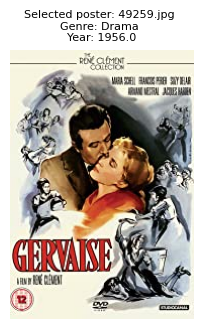

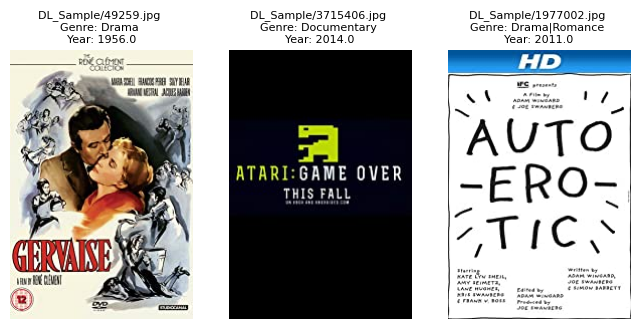

In [16]:
### YOUR CODE HERE
Q_idx = 49259 # YOUR VALUE HERE - DO NOT USE MY VALUE
# imshow(imread(Q_idx))

k = 3 
k_movies = k_nearest(img=f"DL_Sample/{Q_idx}.jpg", k=3, df=df4) # extract the corresponding file name

# plot the selected poster and k most similar posters

# plot the selected poster with the title of file name and genre
fig1 = plt.figure(figsize=(3.5, 3.5))
imshow(imread(Q_idx))
plt.title(f"Selected poster: {Q_idx}.jpg \nGenre: {df4.loc[df4.index == Q_idx, 'Genre'].item()} \nYear: {df4.loc[df4.index == Q_idx, 'Year'].item()}", fontsize=8)

# plot the k most similar poster with the title of file name and genre
fig2 = plt.figure(figsize=(8, 8))
for i, m in enumerate(k_movies):
    #plt.figure()
    im = imread(f"DL_Sample/{m}.jpg")
    fig2.add_subplot(1, 3, i+1)    
    imshow(im)
    plt.title(f"DL_Sample/{m}.jpg \nGenre: {df4.loc[df4.index == m, 'Genre'].item()} \nYear: {df4.loc[df4.index == m, 'Year'].item()}", fontsize=8)

The similarity of the images is calculated by using the Manhattan Distance of the embeddings of the image. The three nearest images (including the selected image) are similar in genre. But they are dissimilar in an era like the selected poster is in 1956, whereas the other two are in 2014 and 2011. They are also dissimilar in the image resolution and the style of images. I agree with the choice and the ranking cause the nearest posters are in a similar genre. The nearest neighbours are not from the same era in this case.

### Part 4: Year regression [5 marks]

Let's investigate the last question ("similar era") above by running **regression** on the year, ie attempt to predict the year, given the poster. Use a train-test split. Build a suitable Keras neural network model for this, **as a regression head on top of the embedding from Part 1**. Include comments to explain the purpose of each part of the model. It should be possible to make a prediction, given a new poster (not part of the original dataset). Write a short comment on model performance: is it possible to predict the year? Based on this result, are there trends over time?

In [17]:
""" Preprocessing the data
    1. deleting the data with 'nan' value of the Year.
    2. get the number of classes as the output dimension.
    3. Create embeddings of the values of Year
"""

# deleting the nan value of the Year column.
indices = list(np.where(df4['Year'].isna()))[0].tolist() # take the rows whose values are not nan
new_years = np.delete(years, indices) # shape = (1238)
new_img_array = np.delete(img_array, indices, axis=0) # generating new img_array by deleting the img with nan value of Year.
                                                      # shape = (1238, 268, 182, 3)

new_years_unique = np.unique(new_years) # get the unique years as the classes
new_years_unique = sorted(new_years_unique) # sort the year 

#get the number of classes as the output dimension.
num_classes = len(new_years_unique) # num_classes = 97


# # Create embeddings of the values of Year
# def year_embeddings(df4, new_years, num_classes, new_years_unique):
    
#     dict_year_emb = {}
#     year_emb = np.zeros((len(new_years), num_classes))

#     for i, year in enumerate(new_years_unique):
#         emb = [0] * num_classes
#         emb[i] += 1
#         dict_year_emb[year] = emb

#     for i, year in enumerate(new_years):
#         year_emb[i] = dict_year_emb[year]
   
#     return dict_year_emb, year_emb

# dict_year_emb, year_emb = year_embeddings(df4=df4, 
#                                           new_years=new_years,
#                                           num_classes=num_classes, 
#                                           new_years_unique=new_years_unique)


In [18]:
""" Load the Data
    1. Spliting train and test data
    2. Scaling images to [0, 1] images
"""

# tran, test split
# X_train, X_test, y_train, y_test = train_test_split(new_img_array, year_emb, test_size=0.3) # X_train.shape=(866, 268, 182, 3)
                                                                                            # y_train.shape=(866, 97)
                                                                                            # X_test.shape=(372, 268, 182, 3)
                                                                                            # y_test.shape=(372, 97)

X_train, X_test, y_train, y_test = train_test_split(new_img_array, new_years, test_size=0.3) # X_train.shape=(866, 268, 182, 3)
                                                                                            # y_train.shape=(866,)
                                                                                            # X_test.shape=(372, 268, 182, 3)
                                                                                            # y_test.shape=(372,)
            
# Scaling images to [0, 1] images
X_train = X_train.astype("float32") / 255 # X_train.shape=(866, 268, 182, 3) 
X_test = X_test.astype("float32") / 255   # X_test.shape=(372, 268, 182, 3)

In [23]:
""" Model of regression based on years
    1. Create input format
    2. Build new model
    3. Prepare the model to train
"""

# create input format (268, 182, 3)
input_tensor = Input(shape=(268, 182, 3))

## build new model

# put the input tensor into the base model
output_model_part1 = model(input_tensor) 

# add 3 fully connected layers with activation function 'relu'
x = layers.Dense(1024, activation='relu')(output_model_part1)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)

# add a logistic layer with softmax activation function
# x = layers.Dense(num_classes, activation='softmax')(x)
x = layers.Dense(1)(x)


# the model to train
new_model = Model(inputs=input_tensor, outputs=x)

# show the architexture of the model
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 268, 182, 3)]     0         
                                                                 
 model (Functional)          (None, 20480)             14714688  
                                                                 
 dense (Dense)               (None, 1024)              20972544  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 36,343,617
Trainable params: 36,343,617
Non-t

In [25]:
""" Training process
    1. Set the hyperparameters
    2. Compile the model
    3. Train the model
    4. Save the model
"""

# set the hyperparameters
batch_size = 128
epochs = 15

# compile the model
new_model.compile(loss="mean_squared_logarithmic_error", optimizer="adam")

# train the model
new_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

# save the model
new_model.save("poster_year.saved_model")

Epoch 1/15


2023-03-02 20:45:55.144195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 4.1476 

2023-03-02 20:47:00.124671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 67s 9s/step - loss: 4.1476 - val_loss: 0.2703
Epoch 2/15
7/7 [==============================] - 64s 9s/step - loss: 0.2395 - val_loss: 0.0710
Epoch 3/15
7/7 [==============================] - 66s 9s/step - loss: 0.1015 - val_loss: 0.0859
Epoch 4/15
7/7 [==============================] - 65s 9s/step - loss: 0.0507 - val_loss: 0.0463
Epoch 5/15
7/7 [==============================] - 62s 9s/step - loss: 0.0246 - val_loss: 0.0133
Epoch 6/15
7/7 [==============================] - 64s 9s/step - loss: 0.0153 - val_loss: 0.0122
Epoch 7/15
7/7 [==============================] - 63s 9s/step - loss: 0.0117 - val_loss: 0.0103
Epoch 8/15
7/7 [==============================] - 63s 9s/step - loss: 0.0099 - val_loss: 0.0098
Epoch 9/15
7/7 [==============================] - 68s 9s/step - loss: 0.0087 - val_loss: 0.0085
Epoch 10/15
7/7 [==============================] - 66s 9s/step - loss: 0.0079 - val_loss: 0.0081
Epoch 11/15
7/7 [==============================] -

INFO:tensorflow:Assets written to: poster_year.saved_model/assets


INFO:tensorflow:Assets written to: poster_year.saved_model/assets


In [27]:
""" Evaluate the model
"""

score = new_model.evaluate(X_test, y_test, verbose=1)
print("Test loss:", score)
print("Test accuracy:", score)

12/12 [==============================] - 6s 483ms/step - loss: 0.0044
Test loss: 0.004367848392575979
Test accuracy: 0.004367848392575979


In [50]:
""" Prediction
"""

# predict 
preds = int(new_model.predict(np.expand_dims(X_test[0], 0)))

print(preds)

# def predict_year(preds, dict_year_emb, ground_true=True):

#     # get the position where the maximum of the predicted embedding is
#     predict_index = np.where(preds[0]==np.max(preds))[0][0] # 94

#     year_list = list(dict_year_emb.keys())
    
#     predicted_year = year_list[predict_index]
    
#     if ground_true:
#         ground_truth_index = np.where(y_test[0] == 1.0)[0][0]
#         ground_truth_year = year_list[ground_truth_index]
#         return f"ground_truth_year: {ground_truth_year}, predicted_year: {predicted_year}"
    
#     return "predicted_year: {predicted_year}"

# predict_year(preds=preds, dict_year_emb=dict_year_emb, ground_true=True)

1/1 [==============================] - 0s 51ms/step
1863


In [33]:
"""Reload the model
"""

model2 = keras.models.load_model('poster_year.saved_model')
score = model2.evaluate(X_test, y_test, verbose=1)
print("Test loss:", score)
print("Test accuracy:", score)

2023-03-02 21:05:29.997762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 6s 484ms/step - loss: 0.0044
Test loss: 0.004367848392575979
Test accuracy: 0.004367848392575979


The model performance is good because the training loss and validation loss are low, and it is possible to predict the year of the corresponding poster. Although the dataset is imbalanced as the figure shows below, the regression task will not be affected by the imbalanced dataset.

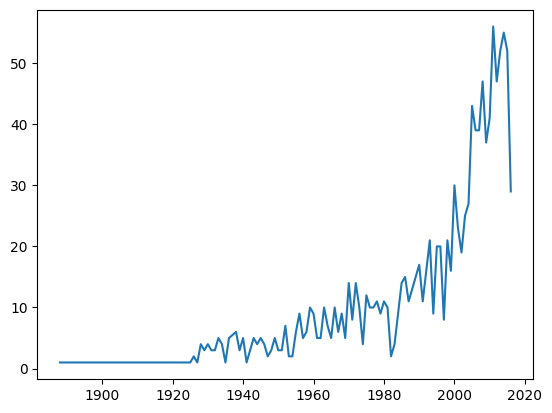

In [34]:
unique, counts = np.unique(new_years, return_counts=True)
d = dict(zip(unique, counts))

lists = sorted(d.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.show()

### Part 5: Improvements [5 marks]

Propose a possible improvement. Some ideas are suggested below. The chosen improvement must be notified to the lecturer at least 1 week before submission and **must be approved by the lecturer to avoid duplication with other students**. Compare the performance between your original and your new model (the proposed improvement might not actually improve on model performance -- that is ok). Some marks will be awarded for more interesting / challenging / novel improvements.

Ideas:

* Try a different pretrained model for creating the embedding
* Alternative ways of reducing the pretrained model's output to a flat vector for the embedding
* Gather more data (see the csv file for URLs)
* Add different architectural details to the regression head
* Fine-tuning
* Training an end-to-end convnet of your own design (no pretraining)
* Improve the embedding by training a multi-headed model, eg predicting both genre and year
* Create a good visualisation of the embedding.


In [ ]:
### YOUR CODE HERE

In [35]:
# try ResNet50 as a pretrained model 
base_model_resnet50 = ResNet50(weights='imagenet', include_top=False) 

# create input format (268, 182, 3)
input_tensor = Input(shape=(268, 182, 3))

# put the input tensor into the base model
output_resnet50_conv = base_model_resnet50(input_tensor) 

# add a flatten layer
x = layers.Flatten(name='flatten')(output_resnet50_conv)

# the model to train
model_resnet50 = Model(inputs=input_tensor, outputs=x)

model_resnet50.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 268, 182, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 flatten (Flatten)           (None, 110592)            0         
                                                                 
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [40]:
""" New Model of regression based on years with pretrained ResNet50
    1. Create input format
    2. Build new model
    3. Prepare the model to train
"""

# create input format (268, 182, 3)
input_tensor = Input(shape=(268, 182, 3))

## build new model

# put the input tensor into the base model
output_model_part1 = model_resnet50(input_tensor) 

# add 3 fully connected layers with activation function 'relu'
x = layers.Dense(1024, activation='relu')(output_model_part1)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)

# add a logistic layer with softmax activation function
x = layers.Dense(1)(x)

# the model to train
new_model_resnet50 = Model(inputs=input_tensor, outputs=x)

# show the architexture of the model
new_model_resnet50.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 268, 182, 3)]     0         
                                                                 
 model_2 (Functional)        (None, 110592)            23587712  
                                                                 
 dense_16 (Dense)            (None, 1024)              113247232 
                                                                 
 dense_17 (Dense)            (None, 512)               524800    
                                                                 
 dense_18 (Dense)            (None, 256)               131328    
                                                                 
 dense_19 (Dense)            (None, 1)                 257       
                                                                 
Total params: 137,491,329
Trainable params: 137,438,209
Non

In [41]:
""" Training process
    1. Set the hyperparameters
    2. Compile the model
    3. Train the model
    4. Save the model
"""

# set the hyperparameters
batch_size = 128
epochs = 15

# compile the model
new_model_resnet50.compile(loss="mean_squared_logarithmic_error", optimizer="adam")

# train the model
new_model_resnet50.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

# save the model
new_model_resnet50.save("poster_year_resnet50.saved_model")

Epoch 1/15


2023-03-02 21:13:41.151948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 9.2253 

2023-03-02 21:14:48.888878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 71s 9s/step - loss: 9.2253 - val_loss: 1.2375
Epoch 2/15
7/7 [==============================] - 62s 8s/step - loss: 0.8858 - val_loss: 6.7747
Epoch 3/15
7/7 [==============================] - 48s 7s/step - loss: 0.2376 - val_loss: 20.7025
Epoch 4/15
7/7 [==============================] - 46s 6s/step - loss: 0.0404 - val_loss: 12.9429
Epoch 5/15
7/7 [==============================] - 52s 7s/step - loss: 0.0113 - val_loss: 11.0389
Epoch 6/15
7/7 [==============================] - 45s 6s/step - loss: 0.0084 - val_loss: 5.8552
Epoch 7/15
7/7 [==============================] - 44s 6s/step - loss: 0.0051 - val_loss: 3.4218
Epoch 8/15
7/7 [==============================] - 47s 7s/step - loss: 0.0028 - val_loss: 2.4277
Epoch 9/15
7/7 [==============================] - 59s 8s/step - loss: 0.0018 - val_loss: 1.2778
Epoch 10/15
7/7 [==============================] - 55s 7s/step - loss: 0.0014 - val_loss: 0.9401
Epoch 11/15
7/7 [==============================

INFO:tensorflow:Assets written to: poster_year_resnet50.saved_model/assets


INFO:tensorflow:Assets written to: poster_year_resnet50.saved_model/assets


In [42]:
""" Evaluate the model
"""

score = new_model_resnet50.evaluate(X_test, y_test, verbose=1)
print("Test loss:", score)
print("Test accuracy:", score)

12/12 [==============================] - 5s 404ms/step - loss: 6.9293e-04
Test loss: 0.0006929279770702124
Test accuracy: 0.0006929279770702124


In [44]:
"""Reload the model
"""

model_resnet50_2 = keras.models.load_model('poster_year_resnet50.saved_model')
score = model_resnet50_2.evaluate(X_test, y_test, verbose=1)
print("Test loss:", score)
print("Test accuracy:", score)

2023-03-02 21:27:43.634272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 6s 405ms/step - loss: 6.9293e-04
Test loss: 0.0006929279770702124
Test accuracy: 0.0006929279770702124


The improvement in this part is applying a different pretrained model — ResNet50 — to improve the performance in part 5. Compared with the original base model -- VGG16 -- applied from part 1 to part 4, the performance of the new model on all the losses (training, validation and testing) is smaller than the losses in the original model. The reasons are: 1) the pretrained ResNet50 architecture is deeper than the original applied pretrained VGG model, and 2) the pretrained ResNet50 architecture avoids the gradient vanishment and speed the learning process by leveraging residual connections that improve the performance of the new model.  